In [100]:
## five data cleaning techniques
# 1.Identify missing values, outliers, and inconsistencies.
# 2.Clean missing data, remove duplicates, standardize text.
# 3.Handle outliers and convert data types.
# 4.Create new features, normalize data, and encode categorical variables.
# 5.Save the cleaned and transformed dataset.

(3109, 24)


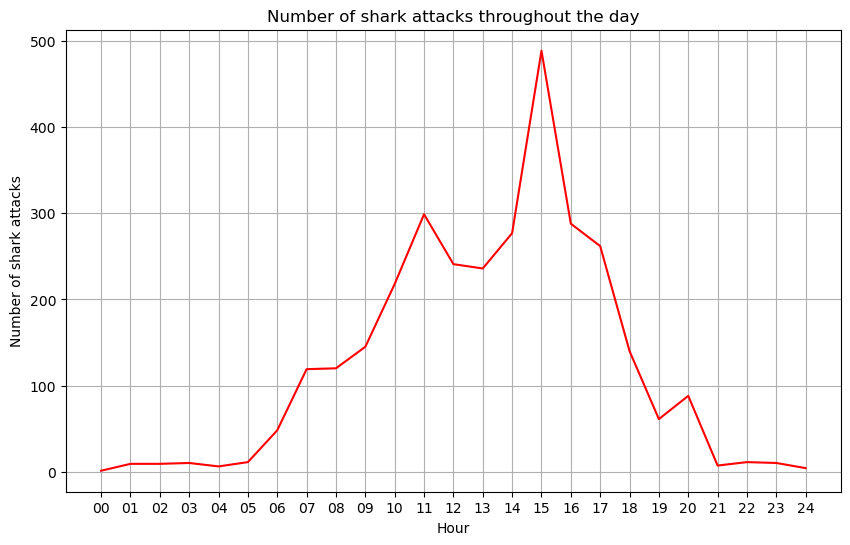

Activity
Surfing         1121
Swimming         976
                 611
Fishing          488
Spearfishing     382
dtype: int64


,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Species,Source,pdf,href formula,href,Case Number,Case Number.1,Original Order,Unnamed: 21,Unnamed: 22
0,15 Mar 2024,2024,Unprovoked,AUSTRALIA,Queensland,Bargara Beach,Swimming,Brooklyn Sauer,F,13,...,Tiger shark,"Yahoo News, 3/15/2024",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,04 Mar 2024,2024,Unprovoked,USA,Hawaii,"Old Man's, Waikiki",Surfing,Matthew White,M,,...,Tiger shark 8',"Surfer, 3/6/2024F",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,02 Mar-2024,2024,Unprovoked,USA,Hawaii,"Rainbows, Oahu",Swimming,,F,11,...,3' to 4' shark,"Hawaii News Now, 3/4/2024",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25 Feb-2024,2024,Unprovoked,AUSTRALIA,Western Australia,"Sandlnd Island, Jurian Bay",,,F,46,...,Tiger shark,"WA Today, 2/26/2024",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14 Feb-2024,2024,Unprovoked,INDIA,Maharashtra,"Vaitarna River, Palghar District",Fishing,Vicky Suresh Govari,M,32,...,"Bull shark, 7'","Times of India, 2/14/2024",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6964,nan,nan,NaN,NaN,NaN,NaN,,,,,...,NaN,NaN,NaN,http://sharkattackfile.net/spreadsheets/pdf_di...,NaN,NaN,NaN,NaN,NaN,NaN
6965,nan,nan,NaN,NaN,NaN,NaN,,,,,...,NaN,NaN,NaN,http://sharkattackfile.net/spreadsheets/pdf_di...,NaN,NaN,NaN,NaN,NaN,NaN
6966,nan,nan,NaN,NaN,NaN,NaN,,,,,...,NaN,NaN,NaN,http://sharkattackfile.net/spreadsheets/pdf_di...,NaN,NaN,NaN,NaN,NaN,NaN
6967,nan,nan,NaN,NaN,NaN,NaN,,,,,...,NaN,NaN,NaN,http://sharkattackfile.net/spreadsheets/pdf_di...,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
from functions import clean_dates, clean_year_column, replace_with_average, extract_numbers, clean_age, clean_gender_column, remove_female_and_nan
import matplotlib.pyplot as plt
#########################################  Load and inspect raw data file ###########################################

##Read excel file
url = 'https://www.sharkattackfile.net/spreadsheets/GSAF5.xls'
df = pd.read_excel(url)


df['Date'] = df['Date'].apply(clean_dates)

df['Year'] = df['Year'].apply(clean_year_column)

############################################  Type Column  #########################################################
df["Type"] = df["Type"].str.strip()
df["Type"] = df["Type"].replace(['Unverified', 'Questionable', 'Under investigation'], 'Unconfirmed')
df["Type"] = df["Type"].replace('?', np.nan)


############################################  Activity Column  ####################################################

df['Activity'] = df['Activity'].astype(str).replace('nan', '')
df['Activity'] = df['Activity'].str.replace(r'^\d+$', '', regex=True)


############################################  Name Column  ####################################################
df['Name'] = df['Name'].apply(remove_female_and_nan)

############################################  Sex Column  #########################################################
df['Sex'] = df['Sex'].apply(clean_gender_column)

############################################  Age Column  #########################################################

#Replace two numbers which has & with average result of two numbers
df['Age'] = df['Age'].apply(replace_with_average)

#Find all numbers (including decimals) in the string
df['Age'] = df['Age'].apply(extract_numbers).astype(float).round().astype('Int64')

#remove ½ and keep only numbers
df['Age'] = df['Age'].apply(clean_age).astype(float).round().astype('Int64')

#Replace <NA> with empty values
df['Age'] = df['Age'].astype(str).replace('<NA>', '')

############################################  Injury Column  #########################################################
df["Injury"] = df["Injury"].str.strip()
# rename to fatal if fatal is in string
df["Injury"] = df["Injury"].apply(lambda x: "Fatal" if pd.notna(x) and "FATAL" in x.upper() and "NOT FATAL" not in x.upper() else x)

# rename non Fatal if "Fatal" not in string
df["Injury"] = df["Injury"].apply(lambda x: "Non-Fatal" if x != "Fatal" else x) 

############################################  Species Column  #########################################################
df = df.rename(columns={'Species ': 'Species'})
df = df.rename(columns={'original order': 'Original Order'})

############################################  Time Column  #########################################################
time_list = list(df["Time"].unique())
pattern = r'\d{2}h\d{2}'

time_list = [item for item in time_list if isinstance(item, str) and re.search(pattern, item)]

time_list

replaced_list = []

for time in time_list:
    if "-" in time:
        replaced_list.append(time)

replaced_list

df["Time"] = df["Time"].replace({'-16h30':'16h30',
 '09h00-10h00':'09h30',
 '14h00-15h00':'14h30',
 '14h00  -15h00':'14h30',
 '10h45-11h15':'11h00',
 '07h00 - 08h00':'07h30',
 '18h15-18h30':'18h30',
 '09h00 - 09h30':'09:15',
 '10h00 -- 11h00':'10h30',
 '09h00 -10h00':'09h30',
 '14h00 - 15h00':'14h40',
 '03h45 - 04h00':'04h00',
 '11h01 -time of ship sinking':'11h00',
 'Ship aban-doned at 03h10':'03h00',
 '06h00 -- 07h00':'06h30',
 '17h00-18h00':'17h30',
 '19h00-20h00':'19h30'})

df["Time"].unique()

replaced_list_1 = []

for time in df["Time"]:
    # Check if the 'time' is not NaN and does not match the pattern using re.search()
    if pd.notna(time) and not re.search(pattern, str(time)):  # Check for NaN and regex match
        replaced_list_1.append(time)

len(replaced_list_1)
set(replaced_list_1)

df["Time"] = df["Time"].replace({
 '"After dark"':'21h30',
 '"After lunch"':'13h00',
 '"Early evening"':'18h00',
 '"Evening"':'20h00',
 '"Midday"':'12h00',
 '"Night"':'22h00',
 '"shortly before dusk"':'06h00',
 'After Dusk':'09h00',
 'After dusk':'09h00',
 'After midnight':'01h00',
 'After noon':'13h00',
 'Afternoon':'15h00',
 'Before daybreak':'06h00',
 'Dark':'22h00',
 'Dawn':'20h00',
 'Daybreak':'08h00',
 'Daytime':'12h00',
 'Dusk':'08:00',
 'Early  morning':'07h00',
 'Early Morning':'07h00',
 'Early afternoon':'14h00',
 'Early morning':'07h00',
 'Evening':'20h00',
 'Just before dawn':'20h00',
 'Just before noon':'11h00',
 'Just before sundown':'19h00',
 'Late Afternoon':'17h00',
 'Late afternon':'17h00',
 'Late afternoon':'17h00',
 'Late morning':'10h00',
 'Late night':'23h00',
 'Lunchtime':'12h00',
 'Mid afternoon':'15h00',
 'Mid morning':'15h00',
 'Mid-morning':'15h00',
 'Midday':'12h00',
 'Midday.':'12h00',
 'Midnight':'24h00',
 'Morning':'08:00',
 'Morning ':'08:00',
 'Night':'22:00',
 'Nightfall':'21:00',
 'Noon':'12h00',
 'Shortly after midnight':'01:00',
 'Sunset':'20h00',
 'dusk':'08h00',
 'night':'22h00','01:00':'01h00',
 '0500':'05h00',
 '06j00':'22h00',
 '0830':'08h30',
 '08:00':'08h00',
 '09:15':'09h15',
 '10j30':'10h30',
 '10jh45':'10h45',
 '11hoo':'11h00',
 1300:'13h00',
 1415:'14h15',
 1500:'15h00',
 '15j45':'15h45',
 '1600':'16h00',
 '20:00':'20h00',
 '21:00':'21h00',
 '22:00':'22h00',
 '8:04 pm':'20h00'})

df["Time"].unique()

for time in df["Time"]:
    # Check if the 'time' is not NaN and does not match the pattern using re.search()
    if pd.notna(time) and not re.search(pattern, str(time)):  # Check for NaN and regex match
        replaced_list_1.append(time)

set(replaced_list_1)

pattern = r'\d{2}h\d{2}'

matched_items = [item for item in time_list if re.search(pattern, item)]

# make all remaining data formats in 'Time' that dont match the HHhMM format nan:
df['Time'] = df['Time'].where(df['Time'].str.match(r'^\d{2}h\d{2}$'), np.nan)
df['Time']
df['Time'].isna().sum()

#################################### Hypothesis 1 ######################################
# Analysis and Plotting for 
# Sharks are more likely to attack when provoked than they are unprovoked
df_replaced = df.replace(['Watercraft', 'Invalid', 'Unconfirmed', 'Sea Disaster', 'Boat'], np.nan)
df_cleaned = df_replaced.dropna()
grouped = df_replaced.groupby(['Type','Injury'])['Activity'].count()
grouped

###################################### Hypothesis 2 ################################################
# Analysis and Plotting for H2
# The frequency of shark attacks is higher during the early morning (dawn) and late afternoon (dusk) compared to midday

# create new DF for H2
H2_df = df.copy()

# change time format for plotting
H2_df['Time'].str.replace('h', ':', regex=False)

# dropping all rows that are NaN in the time column
H2_df = H2_df.dropna(subset = 'Time')

# create hour column for plotting (we're ignoring minutes for the plot)
H2_df['Hour'] = H2_df['Time'].str[:2]
print(H2_df.shape)

# groupby hour and then get the nuber of rows
attack_counts = H2_df.groupby('Hour').size()

# plot
plt.figure(figsize=(10, 6))
plt.plot(attack_counts.index, attack_counts.values, linestyle='-', color='r')
plt.title('Number of shark attacks throughout the day')
plt.xlabel('Hour')
plt.ylabel('Number of shark attacks')
plt.grid(True)
plt.savefig('attacks_throughout_day.png')
plt.show()

############################################## Hypothesis 3 ##########################################
# Analysis and Plotting for H4
# Surfing results in a higher number of shark attacks compared to other water-based activities
# create new DF for H4
H4_df = df.copy()
# dropping all rows that are NaN in the time column
H4_df.dropna(subset = 'Activity')
# groupby activity
activity_counts = H4_df.groupby('Activity').size()
# only take those with more than 5 occurences, only take the top 5
filtered_activity_counts = activity_counts[activity_counts > 5].sort_values(ascending = False)[:5]
print(filtered_activity_counts)

#Save cleaned data file
df.to_csv('/Users/rishikeshdhokare/Documents/Ironhack/MiniProject/Quest2-Shark-Attacks/data-cleaning-pandas/sharkattacks_cleaned_data.csv', index=False)
df